In [1]:
import numpy as np
import pandas as pd
from scipy.stats import mode
import warnings
warnings.filterwarnings('ignore')

import matplotlib
import matplotlib.image as img
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline

from sklearn.model_selection import train_test_split, KFold, GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.svm import SVC

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb 
import lightgbm as lgbm
# from catboost import CatBoostClassifier
import catboost as catb


# from sklearn.metrics import mean_squared_error as mse, r2_score as r2

from IPython.display import Image

from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency

In [2]:
TRAIN_PART_PATH = './train.csv'
PREPARED_DATASET_PATH = './train_prepared.csv'
TEST_PART_PATH = './test.csv'

In [3]:
class DataPipeline:
    """Подготовка исходных данных"""
    
    def __init__(self):
        """Параметры класса"""
        self.medians = None
        
    def fit(self, df):
        """Сохранение статистик"""
        
        self.medians = df[['Annual Income', 'Credit Score', 'Months since last delinquent']].median()
        self.mode_1 = df['Years in current job'].mode()[0]
        self.mode_2 = df['Bankruptcies'].mode()[0]
        
        """Трансформация данных"""
        
        # 1.1 Пропуски float
        df[['Annual Income', 'Credit Score', 'Months since last delinquent']] =\
        df[['Annual Income', 'Credit Score', 'Months since last delinquent']].fillna(self.medians)
                
        # 1.2 Пропуски object
        
        df['Years in current job'].fillna(self.mode_1, inplace=True)
        df['Bankruptcies'].fillna(self.mode_2, inplace=True)

        
    def transform(self, df):
        
        # 2. Выбросы (outliers)
        
        df.loc[df['Credit Score'] > 6000, 'Credit Score'] = df['Credit Score'].median()
        df.loc[df['Credit Score'] < 650, 'Credit Score'] = df['Credit Score'].median()
#         df.loc[(df['Maximum Open Credit'] >  1e6) | (df['Maximum Open Credit'] == 0), 'Maximum Open Credit'] = df['Maximum Open Credit'].median()
# #         df.loc[df['Number of Credit Problems'] > 1 , 'Number of Credit Problems'] = 1
#         df.loc[df['Months since last delinquent'] > 40, 'Months since last delinquent'] = df['Months since last delinquent'].median()
#         df.loc[(df['Monthly Debt'] > 50000) |  (df['Monthly Debt'] < 1e3), 'Monthly Debt'] = df['Monthly Debt'].median()
        df.loc[df['Current Loan Amount'] > 1e7, 'Current Loan Amount'] = df['Current Loan Amount'].median()
        df.loc[df['Years of Credit History'] > 25, 'Years of Credit History'] = df['Years of Credit History']. median()
        df.loc[df['Number of Open Accounts'] > 20, 'Number of Open Accounts'] = df['Number of Open Accounts'].median()
#         df.loc[df['Tax Liens'] > 2, 'Tax Liens'] = 2
#         df.loc[df['Bankruptcies'] > 2, 'Bankruptcies'] = 2
        df.loc[(df['Current Credit Balance'] > 1e6), 'Current Credit Balance'] = df['Current Credit Balance'].median()
#         df.loc[(df['Current Credit Balance'] == 0), 'Current Credit Balance'] = df['Current Credit Balance'].median()
#         ######################################
        
        # 3. Новые фичи (features)
        
        #Доля кредита в годовом доходе
#         df['annual_credit_share'] = df['Maximum Open Credit'] / df['Annual Income']
        
        #Доля текущего баланса в текущей задолженности
        df['current_balance_share'] = df['Current Credit Balance'] / df['Current Loan Amount']
        
        
        ########################################
        
#         df_cat = df.groupby(['Home Ownership', 'Years in current job'], as_index=False).median()[['Home Ownership', 'Years in current job', 'Maximum Open Credit']]
#         df_cat = pd.DataFrame(df_cat)
#         df_cat.rename(columns={'Maximum Open Credit': 'median_Maximum Open Credit'}, inplace=True)
#         df = df.merge(df_cat, on=['Home Ownership', 'Years in current job'])
        
        return df

In [4]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
#                 if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
#                     df[col] = df[col].astype(np.float16)
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [5]:
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [6]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [7]:
def balance_df_by_target(df, target_name, method='over'):

    assert method in ['over', 'under', 'tomek', 'smote'], 'Неверный метод сэмплирования'
    
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    if method == 'over':
        for i in range(disbalance_coeff):
            sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
            df = df.append(sample, ignore_index=True)
            
    elif method == 'under':
        df_ = df.copy()
        df = df_[df_[target_name] == minor_class_name]
        tmp = df_[df_[target_name] == major_class_name]
        df = df.append(tmp.iloc[
            np.random.randint(0, tmp.shape[0], target_counts[minor_class_name])
        ], ignore_index=True)

    elif method == 'tomek':
        from imblearn.under_sampling import TomekLinks
        tl = TomekLinks()
        X_tomek, y_tomek = tl.fit_sample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_tomek, y_tomek], axis=1)
    
    elif method == 'smote':
        from imblearn.over_sampling import SMOTE
        smote = SMOTE()
        X_smote, y_smote = smote.fit_sample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_smote, y_smote], axis=1)

    return df.sample(frac=1) 

In [8]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [9]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [10]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [11]:
df_train = pd.read_csv(TRAIN_PART_PATH, sep=',')

pipe = DataPipeline()
pipe.fit(df_train)
df_train = pipe.transform(df_train)

# Home_Ownership_cat(df_train)
# Years_in_current_job_cat(df_train)
# Purpose_cat(df_train)
# Term_cat(df_train)
# Month_cat(df_train)
df_train.to_csv(PREPARED_DATASET_PATH, index=False, encoding='utf-8')
df_train

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,current_balance_share
0,Own Home,482087.0,10+ years,0.0,11.0,17.0,685960.0,1.0,32.0,1.0,debt consolidation,Short Term,309573.0,47386.0,7914.0,749.0,0,0.153069
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,32.0,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1,1.490640
2,Home Mortgage,751412.0,8 years,0.0,11.0,17.0,1182434.0,0.0,32.0,0.0,debt consolidation,Short Term,309573.0,308389.0,13651.0,742.0,0,0.996175
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,32.0,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0,0.789606
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,32.0,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0,0.741489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,Rent,402192.0,< 1 year,0.0,3.0,8.5,107866.0,0.0,32.0,0.0,other,Short Term,129360.0,73492.0,1900.0,697.0,0,0.568120
7496,Home Mortgage,1533984.0,1 year,0.0,10.0,17.0,686312.0,0.0,43.0,0.0,debt consolidation,Long Term,444048.0,456399.0,12783.0,731.0,1,1.027815
7497,Rent,1878910.0,6 years,0.0,12.0,17.0,1778920.0,0.0,32.0,0.0,buy a car,Short Term,309573.0,477812.0,12479.0,748.0,0,1.543455
7498,Home Mortgage,1168386.0,10+ years,0.0,10.0,17.0,1141250.0,0.0,32.0,0.0,debt consolidation,Short Term,615274.0,476064.0,37118.0,731.0,0,0.773743


In [12]:
df_test = pd.read_csv(TEST_PART_PATH, sep=',')
pipe = DataPipeline()
pipe.fit(df_test)
df_test = pipe.transform(df_test)

# Home_Ownership_cat(df_test)
# Years_in_current_job_cat(df_test)
# Purpose_cat(df_test)
# Term_cat(df_test)
# Month_cat(df_test)
df_test.to_csv(PREPARED_DATASET_PATH, index=False, encoding='utf-8')
df_test.tail(10)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,current_balance_share
2490,Home Mortgage,1494464.0,10+ years,0.0,5.0,15.7,553234.0,0.0,30.0,0.0,debt consolidation,Short Term,179784.0,177745.0,3437.0,751.0,0.988659
2491,Rent,916199.0,2 years,0.0,16.0,12.4,316382.0,0.0,73.0,0.0,other,Short Term,442024.0,88521.0,2313.0,738.0,0.200263
2492,Home Mortgage,750500.0,3 years,0.0,5.0,6.3,162998.0,0.0,30.0,0.0,other,Short Term,173800.0,110238.0,5741.0,690.0,0.634281
2493,Rent,2038282.0,10+ years,0.0,15.0,12.6,847000.0,0.0,30.0,0.0,debt consolidation,Short Term,432256.0,88521.0,27177.0,692.0,0.204788
2494,Home Mortgage,907839.0,1 year,0.0,14.0,11.1,438526.0,0.0,30.0,0.0,debt consolidation,Long Term,368786.0,88255.0,18838.0,705.0,0.239312
2495,Home Mortgage,1020053.0,10+ years,0.0,14.0,17.0,559152.0,1.0,68.0,1.0,debt consolidation,Short Term,322366.0,162735.0,15046.0,745.0,0.504814
2496,Home Mortgage,1178475.0,2 years,0.0,15.0,17.0,1737780.0,0.0,77.0,0.0,debt consolidation,Short Term,468512.0,207385.0,32996.0,731.0,0.442646
2497,Home Mortgage,1171806.0,2 years,0.0,10.0,12.8,1706430.0,0.0,30.0,0.0,debt consolidation,Short Term,430496.0,676438.0,36912.0,695.0,1.571299
2498,Rent,723520.0,10+ years,0.0,14.0,17.0,945780.0,0.0,30.0,0.0,debt consolidation,Short Term,257774.0,391248.0,13506.0,744.0,1.517795
2499,Rent,1694439.0,10+ years,0.0,12.0,18.4,1199748.0,1.0,72.0,0.0,debt consolidation,Long Term,763004.0,559531.0,23440.0,731.0,0.733326


In [13]:
pd.get_dummies(df_train['Years in current job'])
df_train = pd.concat([df_train, pd.get_dummies(df_train['Years in current job'])], axis=1)
pd.get_dummies(df_test['Years in current job'])
df_test = pd.concat([df_test, pd.get_dummies(df_test['Years in current job'])], axis=1)

In [14]:
pd.get_dummies(df_train['Home Ownership'])
df_train = pd.concat([df_train, pd.get_dummies(df_train['Home Ownership'])], axis=1)
pd.get_dummies(df_test['Home Ownership'])
df_test = pd.concat([df_test, pd.get_dummies(df_test['Home Ownership'])], axis=1)

In [15]:
pd.get_dummies(df_train['Purpose'])
df_train = pd.concat([df_train, pd.get_dummies(df_train['Purpose'])], axis=1)
pd.get_dummies(df_test['Purpose'])
df_test = pd.concat([df_test, pd.get_dummies(df_test['Purpose'])], axis=1)

In [16]:
pd.get_dummies(df_train['Term'])
df_train = pd.concat([df_train, pd.get_dummies(df_train['Term'])], axis=1)
pd.get_dummies(df_test['Term'])
df_test = pd.concat([df_test, pd.get_dummies(df_test['Term'])], axis=1)

In [17]:
df_train

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,medical bills,moving,other,renewable energy,small business,take a trip,vacation,wedding,Long Term,Short Term
0,Own Home,482087.0,10+ years,0.0,11.0,17.0,685960.0,1.0,32.0,1.0,...,0,0,0,0,0,0,0,0,0,1
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,32.0,0.0,...,0,0,0,0,0,0,0,0,1,0
2,Home Mortgage,751412.0,8 years,0.0,11.0,17.0,1182434.0,0.0,32.0,0.0,...,0,0,0,0,0,0,0,0,0,1
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,32.0,1.0,...,0,0,0,0,0,0,0,0,0,1
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,32.0,0.0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,Rent,402192.0,< 1 year,0.0,3.0,8.5,107866.0,0.0,32.0,0.0,...,0,0,1,0,0,0,0,0,0,1
7496,Home Mortgage,1533984.0,1 year,0.0,10.0,17.0,686312.0,0.0,43.0,0.0,...,0,0,0,0,0,0,0,0,1,0
7497,Rent,1878910.0,6 years,0.0,12.0,17.0,1778920.0,0.0,32.0,0.0,...,0,0,0,0,0,0,0,0,0,1
7498,Home Mortgage,1168386.0,10+ years,0.0,10.0,17.0,1141250.0,0.0,32.0,0.0,...,0,0,0,0,0,0,0,0,0,1


In [18]:
# df_train = reduce_mem_usage(df_train)

In [19]:
# df_test = reduce_mem_usage(df_test)

In [20]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df_train.columns.drop([TARGET_NAME, 'Home Ownership' ,'Years in current job', 
                                    'Purpose','Months since last delinquent', 'Term', 'renewable energy', '10+ years', 
                                            '< 1 year']).tolist()

# NUM_FEATURE_NAMES = ['Annual Income', 'Number of Open Accounts', 'Years of Credit History', 'Number of Credit Problems',
#                      'Current Loan Amount',
#                      'Current Credit Balance', 'Monthly Debt', 'Credit Score', 'annual_credit_share', 'current_balance_share',
#                      'median_Maximum Open Credit']
NUM_FEATURE_NAMES = ['Annual Income', 'Number of Open Accounts', 'Years of Credit History', 'Number of Credit Problems',
                     'Current Loan Amount',
                     'Current Credit Balance', 'Monthly Debt', 'Credit Score', 'current_balance_share']
CAT_FEATURE_NAMES = ['1 year', '2 years', '3 years', '4 years', '5 years', '6 years', '7 years',
                    '8 years', '9 years', 'Have Mortgage', 'Home Mortgage', 'Own Home', 'Rent', 
                    'business loan', 'buy a car', 'buy house', 'debt consolidation', 'educational expenses', 
                    'home improvements', 'major purchase', 'medical bills', 'moving', 'other', 'small business',
                    'small business', 'take a trip', 'vacation', 'wedding', 'Long Term', 'Short Term']

In [21]:
X = df_train.drop(columns=[TARGET_NAME, 'Home Ownership', '< 1 year','renewable energy','10+ years', 'Years in current job', 
                                    'Purpose','Months since last delinquent', 'Term', 'renewable energy'])
y = df_train[TARGET_NAME]

X_train = df_train.drop(columns=[TARGET_NAME, 'Home Ownership', '< 1 year', '10+ years', 'renewable energy', 'Years in current job', 
                                    'Purpose','Months since last delinquent', 'Term', 'renewable energy'])
y_train = df_train[TARGET_NAME]

# X_test = df_test.drop(columns=[TARGET_NAME] + CAT_FEATURE_NAMES)
# y_test = df_test[TARGET_NAME]

In [22]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME, method='smote')
    
df_balanced[TARGET_NAME].value_counts()

1    5387
0    5387
Name: Credit Default, dtype: int64

In [23]:
X_train_balanced = df_balanced.drop(columns=TARGET_NAME)
y_train_balanced = df_balanced[TARGET_NAME]

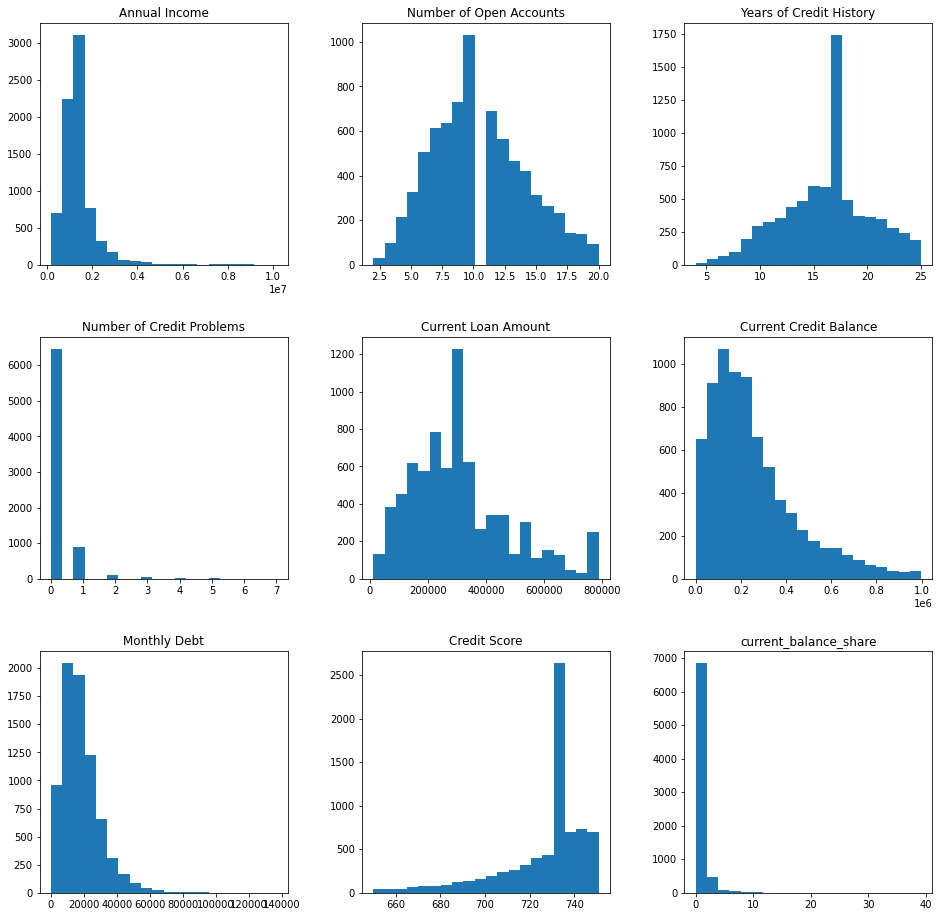

In [24]:
df_train[NUM_FEATURE_NAMES].hist(figsize=(16,16), bins=20, grid=False);

In [25]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.preprocessing import StandardScaler


def imputer_rfr(data, target_col):
    data = data.copy()
    
    features = data.columns
    
    data = data[features]
    
    train = data[~data[target_col].isna()]
    predict_data = data[data[target_col].isna()]

    X = train.drop(columns=[target_col, 'Home Ownership' ,'Years in current job', 
                                    'Purpose','Months since last delinquent', 'Term'])
    y = train[target_col]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.33,
                                                        shuffle=True,
                                                        random_state=21)
    
    model = RandomForestRegressor(n_estimators=50,
                                  max_depth=7,
                                  random_state=21,
                                  verbose=1)
    model.fit(X_train, y_train)
    
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    print(f"r2 на train: {r2_score(y_train, pred_train)}")
    print(f"r2 на test: {r2_score(y_test, pred_test)}")

    pred = model.predict(predict_data.drop(columns=[target_col, 'Home Ownership' ,'Years in current job', 
                                    'Purpose','Months since last delinquent', 'Term']))

    data.loc[data[target_col].isna(), target_col] = list(pred)
    return model, data

In [26]:
df_copy = df_train.copy()
# df_test_copy = df_test.copy()

In [27]:
df_copy.isna().sum().sum()

0

In [28]:
def preprocess_outlier(df, col, threshold):
    # можно по threshold отсекать, а можно и по квантилям
    df.loc[df[col] > threshold, col] = np.nan
    return df

feature_name = 'current_balance_share'
df_copy = preprocess_outlier(df_copy, feature_name, threshold=5)
# df_test_copy = preprocess_outlier(df_test_copy, feature_name, threshold=5)

df_copy[feature_name].isna().sum()

109

In [29]:
%%time
current_balance_share_predictor, df_copy = imputer_rfr(df_copy, feature_name)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


r2 на train: 0.9944164078668885
r2 на test: 0.9855516685848777
Wall time: 1.14 s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


In [30]:
df_copy[feature_name].isna().sum()

0

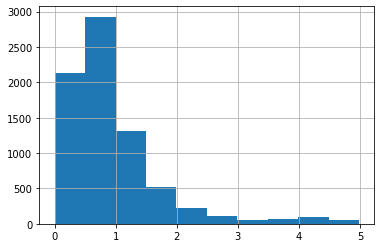

In [31]:
df_copy[feature_name].hist();

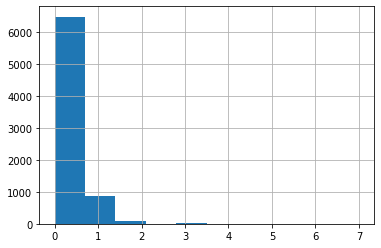

In [32]:
feature_name = 'Number of Credit Problems'
df_copy[feature_name].hist();

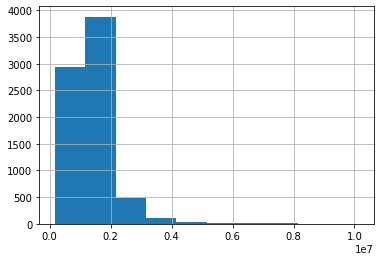

In [33]:
feature_name = 'Annual Income'
df_copy[feature_name].hist();

In [34]:
df_copy = preprocess_outlier(df_copy, feature_name, threshold=0.4 * 10**7)
# df_test_copy = preprocess_outlier(df_test_copy, feature_name, threshold=550000)

df_copy[feature_name].isna().sum()

91

In [35]:
current_balance_share_predictor, df_copy = imputer_rfr(df_copy, feature_name)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


r2 на train: 0.5708809738879894
r2 на test: 0.4294525359191299


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


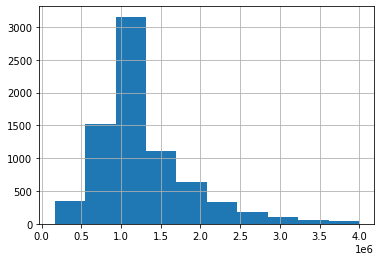

In [36]:
df_copy[feature_name].hist();

In [37]:
df_train = df_copy
df_train

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,medical bills,moving,other,renewable energy,small business,take a trip,vacation,wedding,Long Term,Short Term
0,Own Home,482087.0,10+ years,0.0,11.0,17.0,685960.0,1.0,32.0,1.0,...,0,0,0,0,0,0,0,0,0,1
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,32.0,0.0,...,0,0,0,0,0,0,0,0,1,0
2,Home Mortgage,751412.0,8 years,0.0,11.0,17.0,1182434.0,0.0,32.0,0.0,...,0,0,0,0,0,0,0,0,0,1
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,32.0,1.0,...,0,0,0,0,0,0,0,0,0,1
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,32.0,0.0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,Rent,402192.0,< 1 year,0.0,3.0,8.5,107866.0,0.0,32.0,0.0,...,0,0,1,0,0,0,0,0,0,1
7496,Home Mortgage,1533984.0,1 year,0.0,10.0,17.0,686312.0,0.0,43.0,0.0,...,0,0,0,0,0,0,0,0,1,0
7497,Rent,1878910.0,6 years,0.0,12.0,17.0,1778920.0,0.0,32.0,0.0,...,0,0,0,0,0,0,0,0,0,1
7498,Home Mortgage,1168386.0,10+ years,0.0,10.0,17.0,1141250.0,0.0,32.0,0.0,...,0,0,0,0,0,0,0,0,0,1


In [38]:
df_copy = df_test.copy()

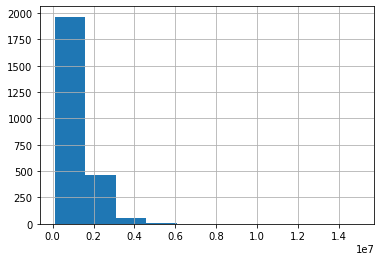

In [39]:
feature_name = 'Annual Income'
df_copy[feature_name].hist();

In [40]:
df_copy = preprocess_outlier(df_copy, feature_name, threshold=0.4 * 10**7)
# df_test_copy = preprocess_outlier(df_test_copy, feature_name, threshold=550000)

df_copy[feature_name].isna().sum()

27

In [41]:
current_balance_share_predictor, df_copy = imputer_rfr(df_copy, feature_name)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


r2 на train: 0.6567769761529128
r2 на test: 0.3734794097327868


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


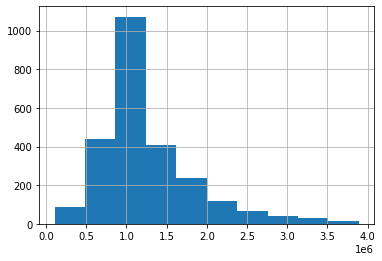

In [42]:
df_copy[feature_name].hist();

In [43]:
df_test = df_copy
df_test

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,major purchase,medical bills,moving,other,small business,take a trip,vacation,wedding,Long Term,Short Term
0,Rent,1178475.0,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,...,0,0,0,0,0,0,0,0,0,1
1,Rent,231838.0,1 year,0.0,6.0,17.0,55946.0,0.0,8.0,0.0,...,0,0,0,0,0,0,0,0,0,1
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,30.0,0.0,...,0,0,0,0,0,0,0,0,0,1
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,...,0,0,0,0,0,0,0,0,0,1
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,30.0,0.0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,Home Mortgage,1020053.0,10+ years,0.0,14.0,17.0,559152.0,1.0,68.0,1.0,...,0,0,0,0,0,0,0,0,0,1
2496,Home Mortgage,1178475.0,2 years,0.0,15.0,17.0,1737780.0,0.0,77.0,0.0,...,0,0,0,0,0,0,0,0,0,1
2497,Home Mortgage,1171806.0,2 years,0.0,10.0,12.8,1706430.0,0.0,30.0,0.0,...,0,0,0,0,0,0,0,0,0,1
2498,Rent,723520.0,10+ years,0.0,14.0,17.0,945780.0,0.0,30.0,0.0,...,0,0,0,0,0,0,0,0,0,1


In [44]:
# scaler = StandardScaler()

# df_norm = df_train.copy()
# df_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUM_FEATURE_NAMES])

# df_train = df_norm.copy()

In [45]:
# scaler = StandardScaler()

# df_norm = df_test.copy()
# df_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUM_FEATURE_NAMES])

# df_test = df_norm.copy()

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,
                                                        shuffle=True,
                                                        random_state=32)

In [47]:
model_lr = LogisticRegression(C=10,
                              max_iter=15
                              )
model_lr.fit(X_train_balanced, y_train_balanced)

evaluate_preds(model_lr, X_train_balanced, X_test, y_train_balanced, y_test)
model_lr.intercept_, model_lr.coef_.mean()

TRAIN

              precision    recall  f1-score   support

           0       0.56      0.57      0.57      5387
           1       0.56      0.56      0.56      5387

    accuracy                           0.56     10774
   macro avg       0.56      0.56      0.56     10774
weighted avg       0.56      0.56      0.56     10774

TEST

              precision    recall  f1-score   support

           0       0.77      0.58      0.66      1072
           1       0.35      0.57      0.44       428

    accuracy                           0.58      1500
   macro avg       0.56      0.58      0.55      1500
weighted avg       0.65      0.58      0.60      1500

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               621  451
1               182  246


(array([4.46920515e-12]), 4.5215450568161944e-08)

In [48]:
%%time
model_svc_1 = SVC(C=10,
                kernel='rbf'
                )
model_svc_1.fit(X_train_balanced, y_train_balanced)

evaluate_preds(model_svc_1, X_train_balanced, X_test, y_train_balanced, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.61      0.42      0.50      5387
           1       0.56      0.73      0.63      5387

    accuracy                           0.57     10774
   macro avg       0.58      0.57      0.56     10774
weighted avg       0.58      0.57      0.56     10774

TEST

              precision    recall  f1-score   support

           0       0.80      0.43      0.56      1072
           1       0.34      0.72      0.46       428

    accuracy                           0.51      1500
   macro avg       0.57      0.58      0.51      1500
weighted avg       0.66      0.51      0.53      1500

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               458  614
1               118  310
Wall time: 20.1 s


In [49]:
%%time
model_svc = SVC(C=1.5,
                kernel='poly',
                degree=2
                )
model_svc.fit(X_train_balanced, y_train_balanced)

evaluate_preds(model_svc, X_train_balanced, X_test, y_train_balanced, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.66      0.04      0.07      5387
           1       0.50      0.98      0.67      5387

    accuracy                           0.51     10774
   macro avg       0.58      0.51      0.37     10774
weighted avg       0.58      0.51      0.37     10774

TEST

              precision    recall  f1-score   support

           0       0.80      0.04      0.07      1072
           1       0.29      0.98      0.44       428

    accuracy                           0.30      1500
   macro avg       0.54      0.51      0.26      1500
weighted avg       0.65      0.30      0.18      1500

CONFUSION MATRIX

col_0            0     1
Credit Default          
0               39  1033
1               10   418
Wall time: 14.1 s


In [50]:
model_xgb = xgb.XGBClassifier(random_state=21, 
                              max_depth=1, 
                              )
model_xgb.fit(X_train_balanced, y_train_balanced)

evaluate_preds(model_xgb, X_train_balanced, X_test, y_train_balanced, y_test)

[18:38:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
TRAIN

              precision    recall  f1-score   support

           0       0.75      0.82      0.78      5387
           1       0.80      0.72      0.76      5387

    accuracy                           0.77     10774
   macro avg       0.77      0.77      0.77     10774
weighted avg       0.77      0.77      0.77     10774

TEST

              precision    recall  f1-score   support

           0       0.78      0.84      0.81      1072
           1       0.50      0.41      0.45       428

    accuracy                           0.71      1500
   macro avg       0.64      0.62      0.63      1500
weighted avg       0.70      0.71      0.70      1500

CONFUSION MATRIX

col_0

In [51]:
params = {
    'reg_lambda': [0.2, 0.5, 0.9, 1.3, 1.9, 3, 5, 10]
}

In [52]:
cv = StratifiedKFold(n_splits=3, random_state=21, shuffle=True)

In [53]:
%%time
grid_search = GridSearchCV(param_grid=params, estimator=model_xgb, cv=cv, verbose=2, scoring='f1')
grid_search.fit(X_train_balanced, y_train_balanced)
display(grid_search.best_params_, grid_search.best_score_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] reg_lambda=0.2 ..................................................
[18:38:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................... reg_lambda=0.2, total=   0.3s
[CV] reg_lambda=0.2 ..................................................
[18:38:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] ................................... reg_lambda=0.2, total=   0.5s
[CV] reg_lambda=0.2 ..................................................
[18:38:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] ................................... reg_lambda=0.2, total=   0.7s
[CV] reg_lambda=0.5 ..................................................
[18:38:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] ................................... reg_lambda=0.5, total=   0.4s
[CV] reg_lambda=0.5 .....

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    8.7s finished


{'reg_lambda': 0.5}

0.7605073543134594

Wall time: 9.26 s


In [54]:
model_xgb = xgb.XGBClassifier(random_state=21, 
                              max_depth=2, 
                              reg_lambda=1.3
                             )
model_xgb.fit(X_train_balanced, y_train_balanced)

evaluate_preds(model_xgb, X_train_balanced, X_test, y_train_balanced, y_test)

[18:38:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
TRAIN

              precision    recall  f1-score   support

           0       0.79      0.89      0.83      5387
           1       0.87      0.76      0.81      5387

    accuracy                           0.82     10774
   macro avg       0.83      0.82      0.82     10774
weighted avg       0.83      0.82      0.82     10774

TEST

              precision    recall  f1-score   support

           0       0.80      0.91      0.85      1072
           1       0.66      0.45      0.53       428

    accuracy                           0.78      1500
   macro avg       0.73      0.68      0.69      1500
weighted avg       0.76      0.78      0.76      1500

CONFUSION MATRIX

col_0

In [55]:
np.linspace(.1, 1.0, 5)

array([0.1  , 0.325, 0.55 , 0.775, 1.   ])

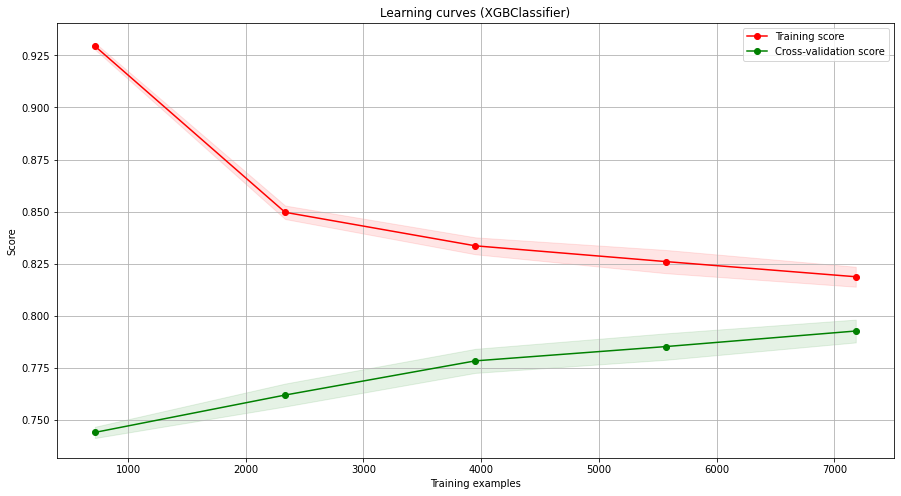

In [56]:
show_learning_curve_plot(model_xgb, X_train_balanced, y_train_balanced)

In [57]:
y_test_pred_probs = model_xgb.predict_proba(X_test)
y_test_pred_probs

array([[0.5902527 , 0.4097473 ],
       [0.80949885, 0.19050114],
       [0.7099623 , 0.2900377 ],
       ...,
       [0.9293441 , 0.07065587],
       [0.6629063 , 0.3370937 ],
       [0.9252654 , 0.07473462]], dtype=float32)

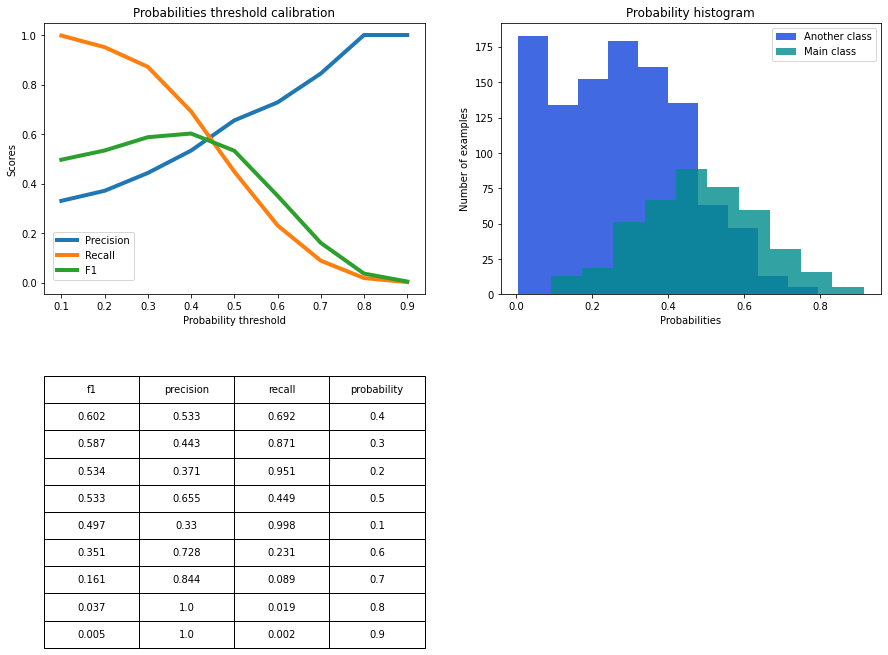

In [58]:
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

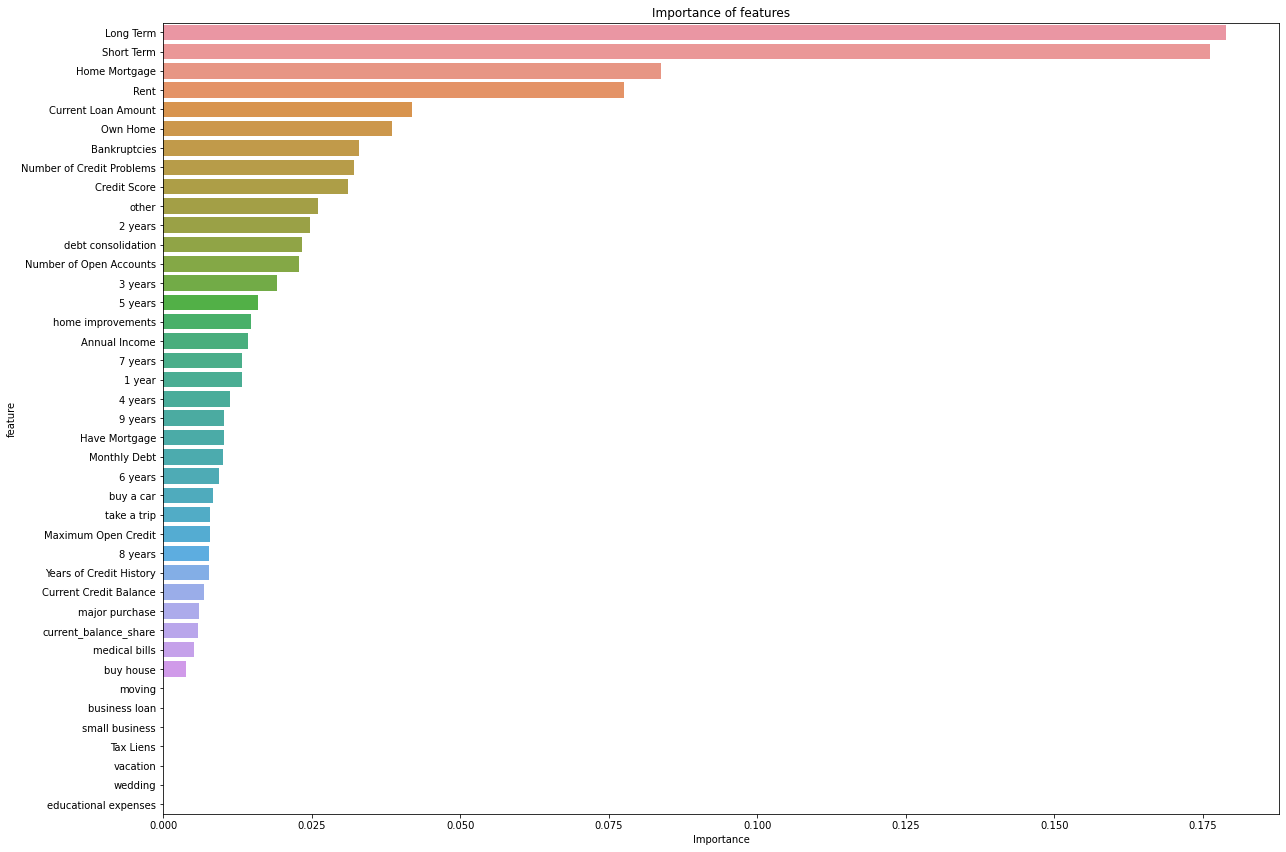

In [59]:
important_features_top = show_feature_importances(X_train_balanced.columns,
                                                  model_xgb.feature_importances_, get_top=10)

In [60]:
important_features_top

['Long Term',
 'Short Term',
 'Home Mortgage',
 'Rent',
 'Current Loan Amount',
 'Own Home',
 'Bankruptcies',
 'Number of Credit Problems',
 'Credit Score',
 'other']

In [61]:
final_xgb = xgb.XGBClassifier(random_state=21, 
                              max_depth=1, 
                              reg_lambda=0.5
                              )
final_xgb.fit(X_train_balanced[important_features_top], y_train_balanced)

evaluate_preds(final_xgb,
               X_train_balanced[important_features_top],
               X_test[important_features_top],
               y_train_balanced,
               y_test)

[18:39:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
TRAIN

              precision    recall  f1-score   support

           0       0.74      0.78      0.76      5387
           1       0.77      0.73      0.74      5387

    accuracy                           0.75     10774
   macro avg       0.75      0.75      0.75     10774
weighted avg       0.75      0.75      0.75     10774

TEST

              precision    recall  f1-score   support

           0       0.78      0.78      0.78      1072
           1       0.45      0.46      0.46       428

    accuracy                           0.69      1500
   macro avg       0.62      0.62      0.62      1500
weighted avg       0.69      0.69      0.69      1500

CONFUSION MATRIX

col_0

### Подготовка Catboost

In [62]:
X = df_train[BASE_FEATURE_NAMES]
y = df_train[TARGET_NAME]

# X_train, X_test, y_train, y_test = train_test_split(X, y,
#                                                     shuffle=True,
#                                                     test_size=0.1,
#                                                     random_state=21,
#                                                     stratify=y)

In [63]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21,
                                     cat_features= CAT_FEATURE_NAMES,
                                     one_hot_max_size=3
                                     )
model_catb.fit(X_train, y_train)

evaluate_preds(model_catb, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.85      0.98      0.91      4315
           1       0.90      0.57      0.70      1685

    accuracy                           0.86      6000
   macro avg       0.88      0.77      0.80      6000
weighted avg       0.87      0.86      0.85      6000

TEST

              precision    recall  f1-score   support

           0       0.77      0.95      0.85      1072
           1       0.72      0.30      0.42       428

    accuracy                           0.77      1500
   macro avg       0.75      0.63      0.64      1500
weighted avg       0.76      0.77      0.73      1500

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1023   49
1                300  128


In [64]:
disbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
disbalance

2.5608308605341246

In [65]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21,
                                     cat_features=CAT_FEATURE_NAMES,
                                     class_weights=[1, disbalance]
                                     )
model_catb.fit(X_train, y_train)

evaluate_preds(model_catb, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.96      0.85      0.90      4315
           1       0.70      0.91      0.79      1685

    accuracy                           0.86      6000
   macro avg       0.83      0.88      0.84      6000
weighted avg       0.89      0.86      0.87      6000

TEST

              precision    recall  f1-score   support

           0       0.82      0.76      0.79      1072
           1       0.49      0.58      0.54       428

    accuracy                           0.71      1500
   macro avg       0.66      0.67      0.66      1500
weighted avg       0.73      0.71      0.72      1500

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               816  256
1               178  250


In [66]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21,
                                     class_weights=[1, disbalance],
                                     eval_metric='F1',
                                     cat_features=CAT_FEATURE_NAMES,
                                     early_stopping_rounds=150,
                                     use_best_model=True,
                                     custom_metric=['Precision', 'Recall']
                                    )
model_catb.fit(X_train, y_train, plot=True, eval_set=(X_test, y_test))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [67]:
model_catb.best_score_

{'learn': {'Recall:use_weights=false': 0.8314540059347181,
  'Logloss': 0.4737300187230266,
  'F1': 0.803906555174193,
  'Precision:use_weights=false': 0.5779702970297029,
  'Precision:use_weights=true': 0.7781259513438767,
  'Recall:use_weights=true': 0.8314540059347181},
 'validation': {'Recall:use_weights=false': 0.6892523364485982,
  'Logloss': 0.5717728887059145,
  'F1': 0.6813953130169461,
  'Precision:use_weights=false': 0.49080882352941174,
  'Precision:use_weights=true': 0.7116811293433515,
  'Recall:use_weights=true': 0.6892523364485982}}

In [68]:
evaluate_preds(model_catb, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.89      0.68      0.77      4315
           1       0.49      0.78      0.60      1685

    accuracy                           0.71      6000
   macro avg       0.69      0.73      0.69      6000
weighted avg       0.77      0.71      0.72      6000

TEST

              precision    recall  f1-score   support

           0       0.84      0.67      0.75      1072
           1       0.45      0.68      0.55       428

    accuracy                           0.68      1500
   macro avg       0.65      0.68      0.65      1500
weighted avg       0.73      0.68      0.69      1500

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               721  351
1               136  292


In [69]:
frozen_params = {
     'class_weights':[1, disbalance], 
     'silent':True,
     'random_state':21,
     'cat_features':CAT_FEATURE_NAMES,
     'eval_metric':'F1',
     'early_stopping_rounds':350
}
model_catb = catb.CatBoostClassifier(**frozen_params)

In [70]:
params = {'iterations':[50, 200, 500, 700, 1500],
          'max_depth':[3, 5, 7]}

In [71]:
cv = StratifiedKFold(n_splits=3, random_state=21, shuffle=True)

In [72]:
# grid_search = model_catb.grid_search(params, X_train, y_train, cv=cv, stratified=True, plot=True, refit=True)

In [73]:
# grid_search

In [74]:
# pd.DataFrame(grid_search['cv_results']).sort_values('test-F1-mean', ascending=False).head()

TypeError: 'GridSearchCV' object is not subscriptable

In [76]:
%%time

final_model = catb.CatBoostClassifier(**frozen_params, iterations=200, max_depth=3)
final_model.fit(X_train, y_train, plot=True, eval_set=(X_test, y_test))

evaluate_preds(final_model, X_train, X_test, y_train, y_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

           0       0.87      0.60      0.71      4315
           1       0.43      0.76      0.55      1685

    accuracy                           0.65      6000
   macro avg       0.65      0.68      0.63      6000
weighted avg       0.74      0.65      0.67      6000

TEST

              precision    recall  f1-score   support

           0       0.85      0.61      0.71      1072
           1       0.43      0.74      0.54       428

    accuracy                           0.65      1500
   macro avg       0.64      0.67      0.63      1500
weighted avg       0.73      0.65      0.67      1500

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               657  415
1               113  315
Wall time: 2.3 s


In [77]:
model = catb.CatBoostClassifier(**frozen_params,
                                iterations=200,
                                max_depth=3, 
#                                 l2_leaf_reg=.5,
                                reg_lambda=0.5
                                )

model.fit(X_train, y_train, plot=True, eval_set=(X_test, y_test))

evaluate_preds(model, X_train, X_test, y_train, y_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

           0       0.86      0.60      0.70      4315
           1       0.42      0.75      0.54      1685

    accuracy                           0.64      6000
   macro avg       0.64      0.67      0.62      6000
weighted avg       0.74      0.64      0.66      6000

TEST

              precision    recall  f1-score   support

           0       0.85      0.63      0.72      1072
           1       0.44      0.73      0.55       428

    accuracy                           0.66      1500
   macro avg       0.65      0.68      0.64      1500
weighted avg       0.74      0.66      0.67      1500

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               671  401
1               115  313


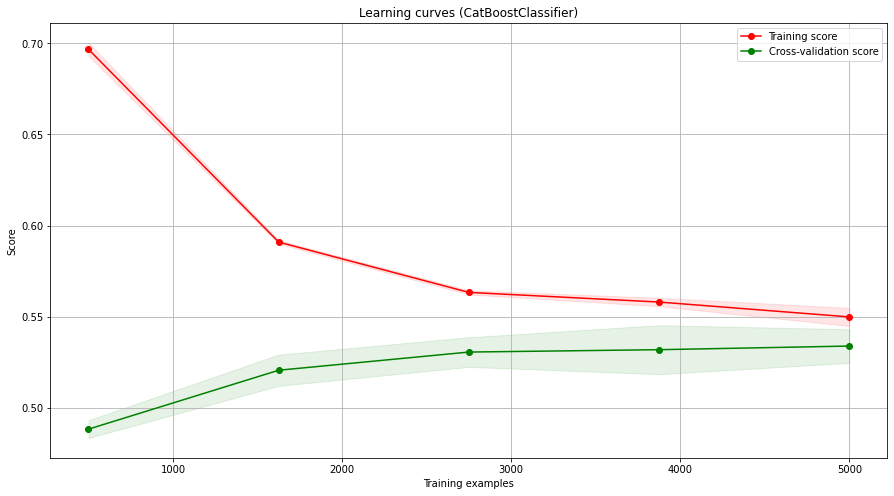

In [78]:
show_learning_curve_plot(model, X, y)

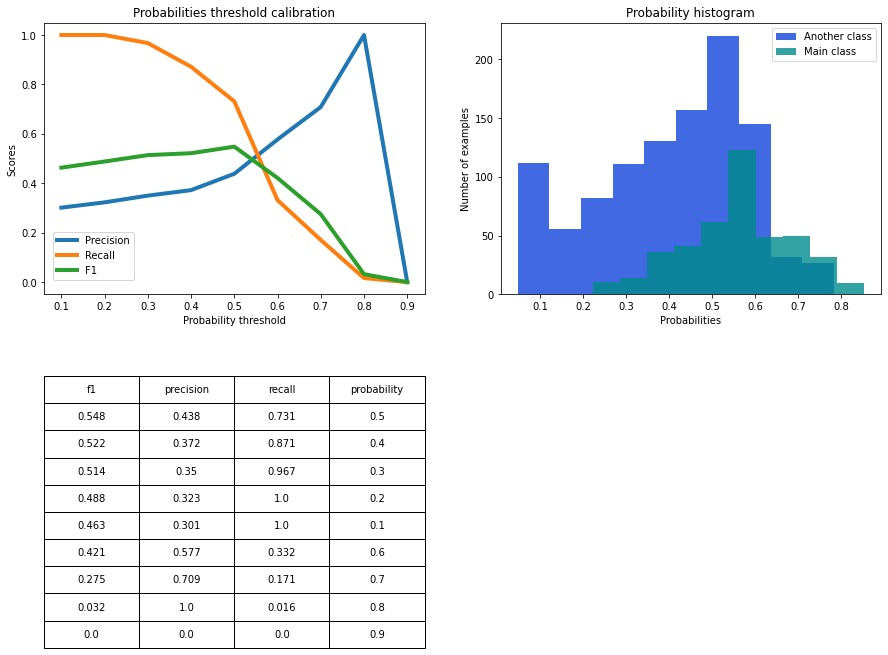

In [79]:
y_test_pred_probs = model.predict_proba(X_test)
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

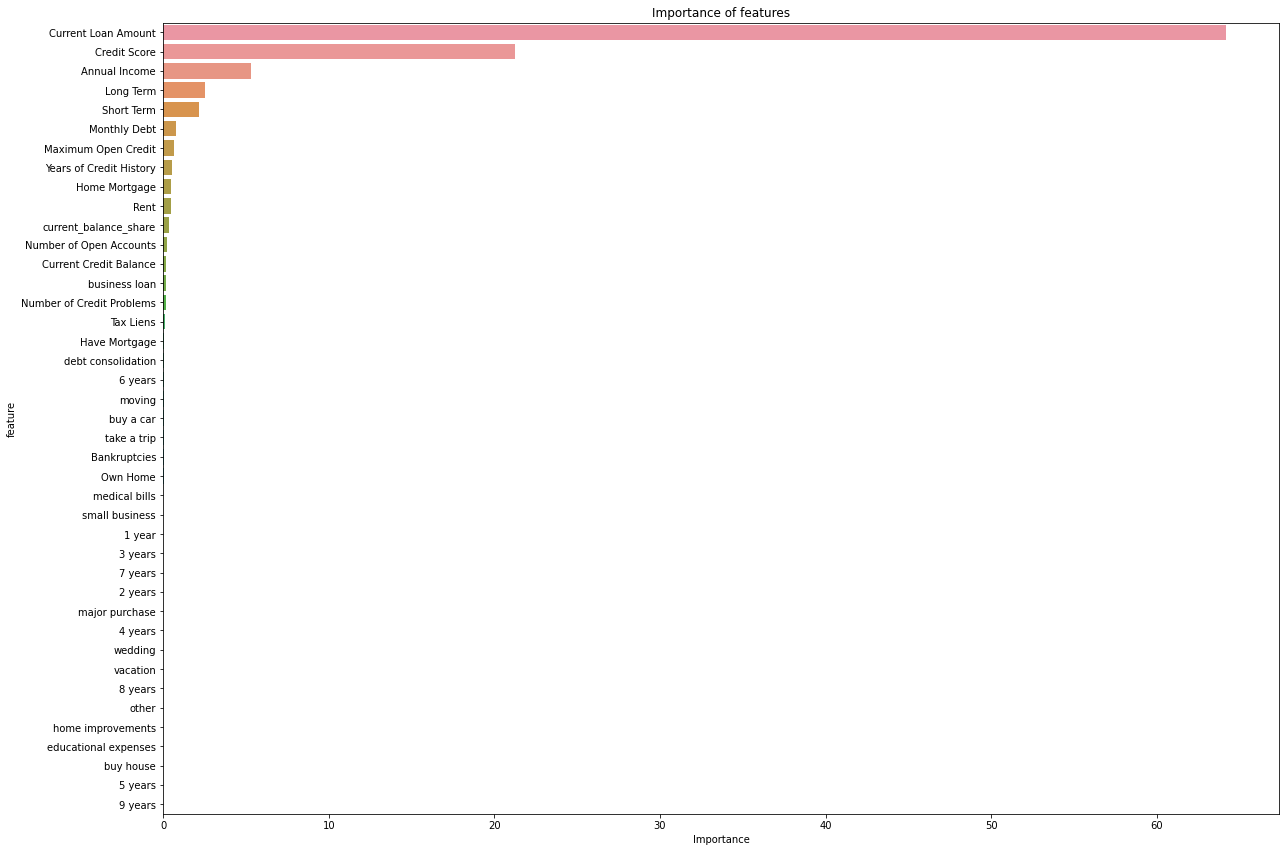

In [85]:
important_features_top = show_feature_importances(X_train.columns, model.feature_importances_, get_top=5)

In [86]:
important_features_top

['Current Loan Amount',
 'Credit Score',
 'Annual Income',
 'Long Term',
 'Short Term']

In [87]:
NEW_CAT_FEATURE_NAMES = list(set(CAT_FEATURE_NAMES).intersection(set(important_features_top)))
NEW_CAT_FEATURE_NAMES

['Long Term', 'Short Term']

In [88]:
%%time

frozen_params = {
     'class_weights':[1, disbalance], 
     'silent':True,
     'random_state':21,
     'cat_features':NEW_CAT_FEATURE_NAMES,
     'eval_metric':'F1',
     'early_stopping_rounds':150
}

final_model = catb.CatBoostClassifier(**frozen_params,
                                      iterations=200,
                                      max_depth=3,
                                      reg_lambda=0.5)

final_model.fit(X_train[important_features_top], y_train)

evaluate_preds(final_model, X_train[important_features_top], X_test[important_features_top], y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.86      0.59      0.70      4315
           1       0.42      0.75      0.54      1685

    accuracy                           0.64      6000
   macro avg       0.64      0.67      0.62      6000
weighted avg       0.74      0.64      0.66      6000

TEST

              precision    recall  f1-score   support

           0       0.84      0.63      0.72      1072
           1       0.43      0.70      0.54       428

    accuracy                           0.65      1500
   macro avg       0.64      0.67      0.63      1500
weighted avg       0.73      0.65      0.67      1500

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               677  395
1               127  301
Wall time: 1.07 s


In [89]:
# X = df_test.drop(columns=['Home Ownership', '< 1 year','10+ years', 'Years in current job', 
#                                     'Purpose','Months since last delinquent', 'Term'])
X = df_test[BASE_FEATURE_NAMES]
# X = df_test[important_features_top]
# X = df_train[BASE_FEATURE_NAMES]

In [90]:
# y_test_preds = final_model.predict(X)
y_test_preds = model.predict(X)



In [91]:
d = {'Id': np.arange(2500), 'Credit Default': y_test_preds}
df2 = pd.DataFrame(data=d)
# df2['Credit Default'] = np.where(df2['Credit Default'] >= 0.25, 1, 0)
df2

,Id,Credit Default
0,0,1
1,1,1
2,2,1
3,3,0
4,4,1
...,...,...
2495,2495,0
2496,2496,1
2497,2497,0
2498,2498,0


In [92]:
df2['Credit Default'].value_counts()

1    1324
0    1176
Name: Credit Default, dtype: int64

In [93]:
df2.to_csv(PREPARED_DATASET_PATH, index=False, encoding='utf-8', sep=',')